In [2]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.io import mmread
import pandas as pd
import matplotlib.pyplot as plt
from mquad.mquad_utils import findKnee, plot_confusionMatrix, confusionMatrix


In [2]:
kim_AD = mmread('/storage/holab/mito/donor1_chrM/cellsnp/cellSNP.tag.AD.mtx')
kim_DP = mmread('/storage/holab/mito/donor1_chrM/cellsnp/cellSNP.tag.DP.mtx')

kim_AF = pd.DataFrame(kim_AD/kim_DP).fillna(0)

kim_AF.shape

(16571, 536)

In [179]:
deltaBIC = []

for i in range(len(kim_AF)):
    X = np.array(kim_AF.loc[i]).reshape(-1, 1)
    gm_1 = GaussianMixture(n_components=1, random_state=0).fit(X)
    gm_2 = GaussianMixture(n_components=2, random_state=0).fit(X)

    deltaBIC.append(gm_1.bic(X) - gm_2.bic(X))

/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/scikit_learn-0.24.2-py3.8-linux-x86_64.egg/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/aaronkwc/.conda/envs/p

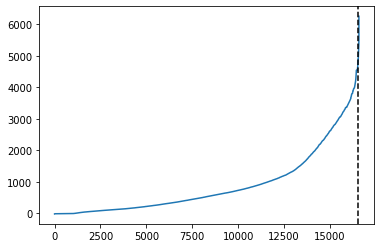

In [180]:
x,y,knee,knee_y = findKnee(np.array(deltaBIC))
plt.plot(range(len(deltaBIC)), np.sort(deltaBIC))
plt.axvline(x=knee*len(deltaBIC), color="black", linestyle='--',label="cutoff")

/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log10(Binomial_deltaBIC)')

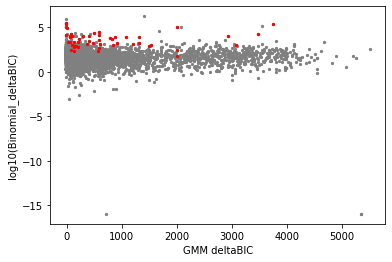

In [203]:
mquad_unsorted = pd.read_csv('/storage/holab/mito/donor1_chrM/cellsnp/mquad/debug_unsorted_BIC_params.csv')
informative = pd.read_csv('simulation/data/donor1_informative_variants.csv')
informative[['ref', 'alt']] = informative.nucleotide.str.split('>', expand=True)
informative['mquad_variant_name'] = 'chrM_' + informative.position.astype(str) + '_' + informative.ref + '_' + informative.alt


plt.scatter(deltaBIC, np.log10(mquad_unsorted.deltaBIC), s=5, color='grey')
plt.scatter(np.array(deltaBIC)[mquad_unsorted.variant_name.isin(informative.mquad_variant_name)], np.log10(mquad_unsorted.deltaBIC[mquad_unsorted.variant_name.isin(informative.mquad_variant_name)]
), color='r', s=5)
plt.xlabel('GMM deltaBIC')
plt.ylabel('log10(Binomial_deltaBIC)')

In [3]:
kim_mgatk = pd.read_csv('kim/data/mgatk/final/misc_df.csv')
kim_mquad = pd.read_csv('kim/data/mquad/BIC_params.csv')
kim_mgatk[['ref', 'alt']] = kim_mgatk.nucleotide.str.split('>', expand=True)
kim_mgatk['mquad_variant_name'] = 'chrM_' + kim_mgatk.position.astype(str) + '_' + kim_mgatk.ref + '_' + kim_mgatk.alt
kim_mgatk['is_detected_by_mquad'] = kim_mgatk.mquad_variant_name.isin(kim_mquad.variant_name)
kim_mgatk['informative'] = (kim_mgatk.strand_correlation >= 0.65) & (np.log10(kim_mgatk.vmr) >= -2) & (kim_mgatk.n_cells_conf_detected > 5) & (kim_mgatk.mean_coverage >= 50)

mgatk_filt = kim_mgatk[(kim_mgatk.n_cells_conf_detected > 5) & (kim_mgatk.strand_correlation >= 0.65) & (kim_mgatk.mean_coverage >= 50) & (kim_mgatk.is_detected_by_mquad == True)]

mgatk_filt.shape

/home/aaronkwc/.conda/envs/pepe/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1639, 18)

In [6]:
kim_mquad['is_in_mgatk'] = kim_mquad.variant_name.isin(mgatk_filt.mquad_variant_name)
kim_mquad_filt = kim_mquad[(kim_mquad.num_cells_minor_cpt > 2) & (kim_mquad.is_in_mgatk == True)]

kim_mquad_filt.shape

(1328, 20)

In [10]:
## 1D clustering of mean AF using k-means
from sklearn.cluster import KMeans

k_means = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, random_state=0, tol=0.0001, verbose=0)

def kmeans_plot(x, lab):
    k_means.fit(np.array(x).reshape(-1,1))
    centroids = k_means.cluster_centers_

    Z = k_means.predict(np.array(x).reshape(-1,1))
    # Plot each class as a separate colour

    n_clusters = 2
    for n in range(n_clusters):
        # Filter data points to plot each in turn.
        xs = x[ Z==n ]
        print("Cluster " + str(n) + " has " + str(len(xs)) + " variants")
        plt.scatter(xs,y=np.repeat(0, len(xs)), label="cluster " + str(n))

    for n, y in enumerate(centroids):
        plt.plot(y, 0, marker='x', color='black',ms=10)

    plt.title("1D K-means on " + lab)
    plt.xlabel(lab)
    plt.legend()

    return Z

Cluster 0 has 1637 variants
Cluster 1 has 2 variants
Precision = 0.9260843005497862
Recall = 0.9959016393442623
Cluster 0 has 1326 variants
Cluster 1 has 2 variants
Precision = 0.9800150829562595
Recall = 0.9818181818181818


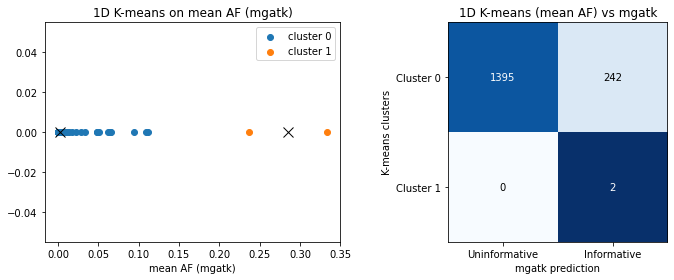

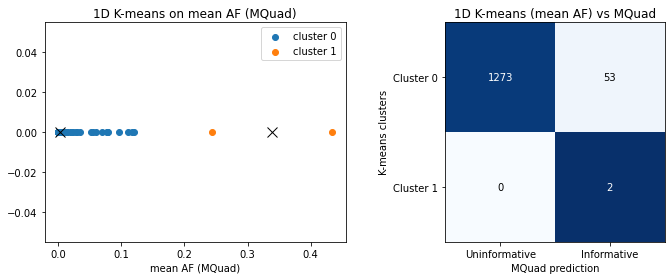

In [11]:
##1D kmeans on mean AF only
mean_AF = mgatk_filt['mean']

fig = plt.figure(figsize=(10,4))

ax = plt.subplot(1,2,1)
res = kmeans_plot(mean_AF, "mean AF (mgatk)")

ax = plt.subplot(1,2,2)
confusion = confusionMatrix(res, mgatk_filt.informative)
res = plot_confusionMatrix(confusion, ax=ax)
plt.title('1D K-means (mean AF) vs mgatk')
plt.ylabel('K-means clusters')
plt.xlabel('mgatk prediction')
plt.xticks(range(2), ['Uninformative', 'Informative'])
plt.yticks(range(len(confusion)), ['Cluster 0', 'Cluster 1'])
plt.tight_layout()



fig = plt.figure(figsize=(10,4))

mean_AF = kim_mquad_filt.total_AD / kim_mquad_filt.total_DP
ax = plt.subplot(1,2,1)
res = kmeans_plot(mean_AF, "mean AF (MQuad)")

ax = plt.subplot(1,2,2)
confusion = confusionMatrix(res, ((kim_mquad_filt.PASS_KP == True) & (kim_mquad_filt.PASS_MINCELLS == True)))
res = plot_confusionMatrix(confusion, ax=ax)
plt.title('1D K-means (mean AF) vs MQuad')
plt.ylabel('K-means clusters')
plt.xlabel('MQuad prediction')
plt.xticks(range(2), ['Uninformative', 'Informative'])
plt.yticks(range(len(confusion)), ['Cluster 0', 'Cluster 1'])
plt.tight_layout()


Cluster 0 has 1628 variants
Cluster 1 has 11 variants
Precision = 0.9284398034398034
Recall = 0.9774590163934427


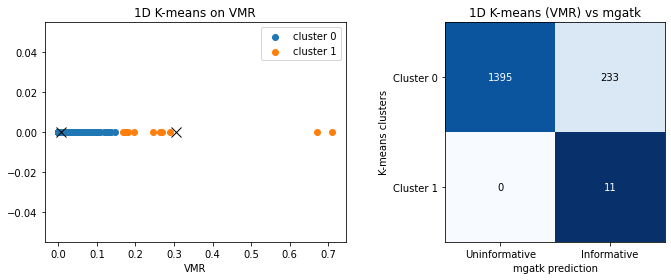

In [12]:
vmr = mgatk_filt.vmr

fig = plt.figure(figsize=(10,4))

ax = plt.subplot(1,2,1)
res = kmeans_plot(vmr, "VMR")

ax = plt.subplot(1,2, 2)
confusion = confusionMatrix(res, mgatk_filt.informative)
res = plot_confusionMatrix(confusion, ax=ax)
plt.title('1D K-means (VMR) vs mgatk')
plt.ylabel('K-means clusters')
plt.xlabel('mgatk prediction')
plt.xticks(range(2), ['Uninformative', 'Informative'])
plt.yticks(range(len(confusion)), ['Cluster 0', 'Cluster 1'])
plt.tight_layout()

Cluster 0 has 1619 variants
Cluster 1 has 20 variants
Precision = 0.9308214947498457
Recall = 0.959016393442623


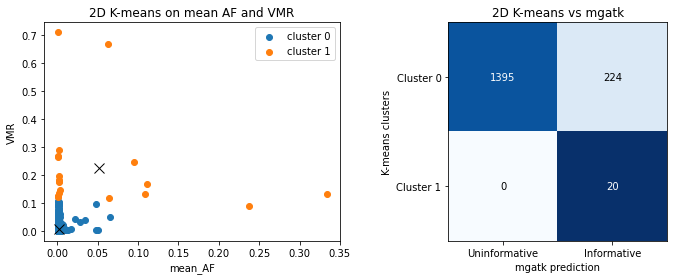

In [13]:
## 2D k-means on mean_AF and VMR
k_means.fit(mgatk_filt[['mean', 'vmr']].values)
centroids = k_means.cluster_centers_

Z = k_means.predict(mgatk_filt[['mean', 'vmr']].values)
# Plot each class as a separate colour
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,2,1)

n_clusters = 2
for n in range(n_clusters):
    # Filter data points to plot each in turn.
    xs = mgatk_filt['mean'][ Z==n ]
    ys = mgatk_filt['vmr'][ Z==n ]
    print("Cluster " + str(n) + " has " + str(len(xs)) + " variants")
    plt.scatter(xs,y=ys, label="cluster " + str(n))

for x, y in enumerate(centroids):
    plt.plot(y[0], y[1], marker='x', color='black',ms=10)

plt.title("2D K-means on mean AF and VMR")
plt.xlabel("mean_AF")
plt.ylabel("VMR")
plt.legend()


ax = plt.subplot(1,2,2)
confusion = confusionMatrix(Z, mgatk_filt.informative)
res = plot_confusionMatrix(confusion, ax=ax)
plt.title('2D K-means vs mgatk')
plt.ylabel('K-means clusters')
plt.xlabel('mgatk prediction')
plt.xticks(range(2), ['Uninformative', 'Informative'])
plt.yticks(range(len(confusion)), ['Cluster 0', 'Cluster 1'])
plt.tight_layout()
